# Analyzing MTA Delays: Insights and Predictive Modeling

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()
#Choose the kaggle.json file that you downloaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jkanishkhajai","key":"3842ec84ee7ab3f6ea495997abc14a64"}'}

In [ ]:
# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

### Installing datasets from custom created Kaggle Dataset.

For Easier Reproducibility and Collaboration, We collected datasets from MTA Website, NYC Open data and other platforms across the internet and pushed it to our custom created Kaggle Dataset.

In [ ]:
#!/bin/bash
!kaggle datasets download jkanishkhajai/mta-nyc-dataset

Dataset URL: https://www.kaggle.com/datasets/jkanishkhajai/mta-nyc-dataset
License(s): MIT
mta-nyc-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/mta-nyc-dataset.zip -d /content/mta-nyc-dataset/

Archive:  /content/mta-nyc-dataset.zip
  inflating: /content/mta-nyc-dataset/ACSST5Y2022.S1810-Data.csv  
  inflating: /content/mta-nyc-dataset/Filtered_Agency_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/Filtered_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/Filtered_MTA_Feedback_2019.csv  
  inflating: /content/mta-nyc-dataset/Filtered_No_Commendation_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/Final_Filtered_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/MTA_Accessibility.csv  
  inflating: /content/mta-nyc-dataset/MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/MTA_NYCT_MetroCard_History__2010_-_2021_20241201.csv  
  inflating: /content/mta-nyc-dataset/MTA_Subway_Accessible_Station_Platform_Availability__Beginning_2018_20241124.csv  
  inflating: /content/mta-nyc-dataset/MTA_Subway_Entrances_and_Exits__2024_20241122.csv  
  inflating: /content/mta-nyc-dataset/MTA_Subway_Hourly_Ridership__Beginning_July_2020_20241122.csv  
  inf

### 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
from scipy import stats
import math

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker

import textwrap
import warnings
warnings.filterwarnings('ignore')

### 2. Import Datasets

In [ ]:
#Delays Data
Delays = pd.read_csv('/content/mta-nyc-dataset/MTA_Subway_Trains_Delayed__Beginning_2020_20241124.csv')
#Monthly Ridership
MonthRidership = pd.read_csv('/content/mta-nyc-dataset/MTA_Subway_Hourly_Ridership__Beginning_July_2020_20241122.csv')
#More Detailed Ridership
RidersComplex = pd.read_csv('/content/mta-nyc-dataset/MTA_Subway_Hourly_Ridership__complex_id_and_name.csv')
#Major Incidents Data
MajorIncidents = pd.read_csv('/content/mta-nyc-dataset/MTA_Subway_Major_Incidents__Beginning_2020_20241118.csv')
#Location Lookup
Stations = pd.read_csv('/content/mta-nyc-dataset/MTA_Subway_Entrances_and_Exits__2024_20241122.csv')

### Analyzing The macro relationship between ridership and delays (per month)

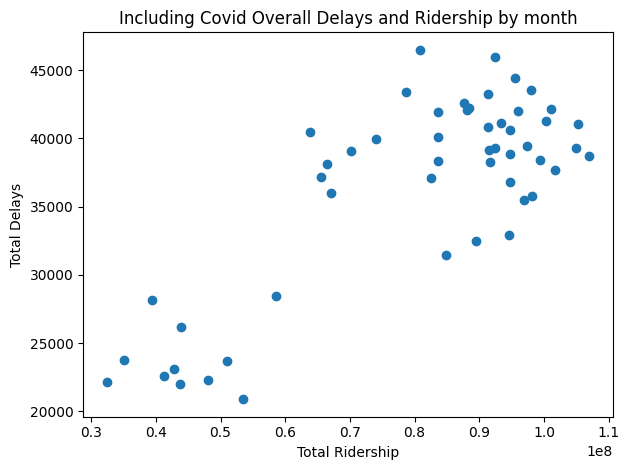

In [ ]:
#Making the delays data monthly
SimpDelays = Delays.groupby(['month']).sum()
SimpDelays = SimpDelays['delays']

#View the overall relationship
plt.scatter(MonthRidership['ridership'],SimpDelays.loc['2020-07-01':])
plt.xlabel('Total Ridership')
plt.ylabel('Total Delays')
plt.title('Including Covid Overall Delays and Ridership by month')
plt.tight_layout()
plt.show()

### Focus on Post Covid Data including a regression

In [ ]:
def LOBF(x,slope,intercept):
    """
    intakes x values used for a 2-d line of best fit and outputs the equation to transform them to y values
    """
    return slope * x + intercept

In [ ]:
#Regression for covid data for appendix/notes
slope, intercept, r, p, std_err = stats.linregress(MonthRidership['ridership'],SimpDelays.loc['2020-07-01':])
print('r is ' + str(r))
print('p is ' + str(p))

r is 0.7986014090311038
p is 1.3125382476550514e-12


r is 0.06619992755705388
p is 0.6809045081347735


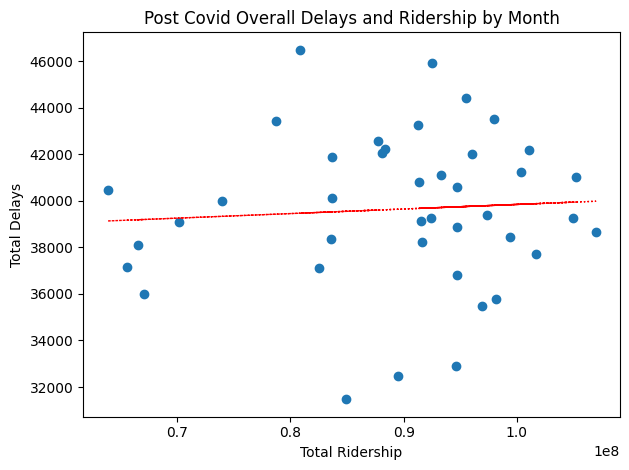

In [ ]:
#Original Regression
slope, intercept, r, p, std_err = stats.linregress(MonthRidership.iloc[11:]['ridership'],SimpDelays.loc['2021-06-01':])
print('r is ' + str(r))
print('p is ' + str(p))
#not very linear
mymodel = list(LOBF(MonthRidership.iloc[11:]['ridership'],slope,intercept))
plt.scatter(MonthRidership.iloc[11:]['ridership'],SimpDelays.loc['2021-06-01':])
plt.plot(MonthRidership.iloc[11:]['ridership'], mymodel, color = 'red', linestyle ='dotted', lw = 1)
plt.xlabel('Total Ridership')
plt.ylabel('Total Delays')
plt.title('Post Covid Overall Delays and Ridership by Month')
plt.tight_layout()
plt.show()

This looks quite randomly distributed and its low r (0.07) shows it is definitely not linear



In [ ]:
#Estimate the delays in 2023
print(SimpDelays.loc['2023-01-01':'2023-12-01'].sum())
print(SimpDelays.loc['2022-01-01':'2022-12-01'].sum())

449652
498487


### Now see if there is a relationship with the lines themselves

In [ ]:
#Extract train lines from ridership data
trainlist = []
for x in RidersComplex['station_complex']:
    trainlist.append(x[x.rfind('('):])
len(trainlist)
RidersComplex['train lines'] = trainlist

#Make a custom list of line values, removing GS and Shuttles
trainlist = ['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F',
       'G',  'J', 'Z', 'L', 'M', 'N', 'Q', 'R']

#Utilize train lines and train list to calculate 'ridership' estimate
trainsums = []
for x in trainlist:
    ridersum = 0
    for y in range(len(RidersComplex['train lines'])):
        if x in RidersComplex['train lines'][y]:
            ridersum += RidersComplex['ridership'][y]
    trainsums.append(ridersum)

In [ ]:
#Construct train line focused dataframe with ridership and delays starting with ridership
TrainLines = pd.DataFrame({'trains': trainlist, 'riderships': trainsums})

#Then delays
lineDelays = Delays.groupby(['line']).sum()
lineDelays = lineDelays['delays']

#removing GS and splitting JZ
lineDelays.rename(index={'GS': 'J', 'JZ':'Z'}, inplace=True)
lineDelays = lineDelays.replace(4046,57780)
#Removing Shuttles
DelaysList = lineDelays.loc[:'R']
#and combine
TrainLines['delays'] = DelaysList.values

#Add a ratio
TrainLines['ratio'] = TrainLines['delays']/TrainLines['riderships']
display(TrainLines.sort_values(by='ratio', ascending = False))

,trains,riderships,delays,ratio
13,G,142053225,57441,0.000404
18,N,424074446,166457,0.000393
12,F,490856911,147647,0.000301
1,2,458514533,131408,0.000287
7,A,584843504,159198,0.000272
11,E,498833386,130419,0.000261
15,Z,243697319,57780,0.000237
5,6,611812922,144997,0.000237
19,Q,470605833,110054,0.000234
10,D,463549728,108186,0.000233


The G and N trains stand out as high delayed per estimated ridership

In [ ]:
#lets perform a regression on this data
slope, intercept, r, p, std_err = stats.linregress(TrainLines['riderships'],TrainLines['delays'])
mymodel = list(LOBF(TrainLines['riderships'],slope,intercept))

print('r is ' + str(r))
print('p is ' + str(p))

r is 0.41792544578370805
p is 0.05939772628152396


The r has improved in this model, can we see it?


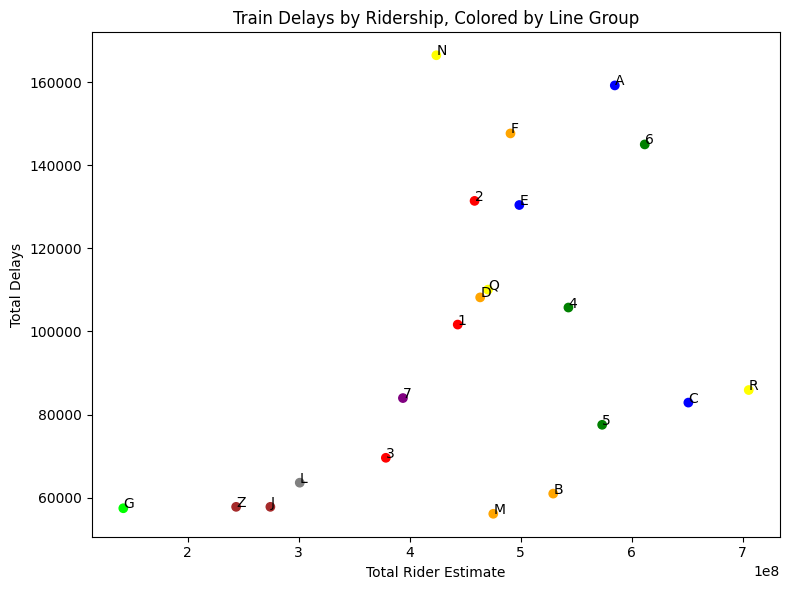

In [ ]:
#Lets visualize

#Load up colors by line group
trainx_colors = {'1':'red','2':'red','3':'red','4':'green','5':'green','6':'green','7':'purple','A':'blue','B':'orange','C':'blue','D':'orange',
'E':'blue','F':'orange','G':'lime','J':'brown','Z':'brown','L':'grey','M':'orange',
'N':'yellow','Q':'yellow','R':'yellow'}

#And go
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.scatter(TrainLines['riderships'],TrainLines['delays'],c=TrainLines['trains'].map(trainx_colors))
#plt.plot(TrainLines['riderships'],mymodel, c = 'navy') #Regression line, looked wiered
plt.xlabel('Total Rider Estimate')
plt.ylabel('Total Delays')
plt.title('Train Delays by Ridership, Colored by Line Group')
for i, txt in enumerate(TrainLines['trains']):
    ax.annotate(txt, (TrainLines['riderships'][i],TrainLines['delays'][i]))
plt.tight_layout()
plt.show()

pattern with G and N trains standing out holds, but G looks a little out of place, can we change that

In [ ]:
#Testing removing G?
GTrainLines = TrainLines.drop([13])
slope, intercept, r, p, std_err = stats.linregress(GTrainLines['riderships'],GTrainLines['delays'])
mymodel = list(LOBF(GTrainLines['riderships'],slope,intercept))
print('r is ' + str(r))

r is 0.34493177318567514


r gets worse when G is removed, lets also vizualize this

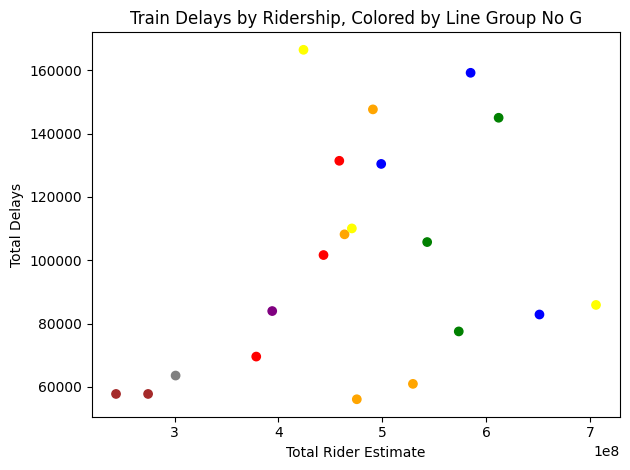

In [ ]:
#Doing the Eye Test on post G train data
traingx_colors = {'1':'red','2':'red','3':'red','4':'green','5':'green','6':'green','7':'purple','A':'blue','B':'orange','C':'blue','D':'orange',
'E':'blue','F':'orange','J':'brown','Z':'brown','L':'grey','M':'orange',
'N':'yellow','Q':'yellow','R':'yellow'}

plt.scatter(GTrainLines['riderships'],GTrainLines['delays'],c=GTrainLines['trains'].map(traingx_colors))
plt.xlabel('Total Rider Estimate')
plt.ylabel('Total Delays')
plt.title('Train Delays by Ridership, Colored by Line Group No G')
plt.tight_layout()
plt.show()

It definitely looks less linear, maybe the other trains are below expected

### Break data out by line and delay category

In [ ]:
#GroupBy the data
DelayGroup = Delays.groupby(['line','reporting_category'],as_index=False)['delays'].sum()

#Create a total per line
DelayLineGroup = Delays.groupby(['line'],as_index=False)['delays'].sum()

#Create a ratio column
DelayRatio = []
for x in range(len(DelayGroup)):
    for y in range(len(DelayLineGroup)):
        if(DelayLineGroup['line'][y] == DelayGroup['line'][x]):
            DelayRatio.append(DelayGroup['delays'][x]/DelayLineGroup['delays'][y])
DelayGroup['ratio'] = DelayRatio

#Observe the most delayed train by reason
DelayGroup.sort_values(by='delays', ascending = False).head(50)

,line,reporting_category,delays,ratio
110,N,Infrastructure & Equipment,45299,0.272136
35,6,Police & Medical,43471,0.299806
76,F,Planned ROW Work,43413,0.294032
70,E,Planned ROW Work,42477,0.325696
74,F,Infrastructure & Equipment,40263,0.272698
68,E,Infrastructure & Equipment,38084,0.292013
46,A,Planned ROW Work,37950,0.238382
112,N,Planned ROW Work,37735,0.226695
44,A,Infrastructure & Equipment,34120,0.214324
32,6,Infrastructure & Equipment,33910,0.233867


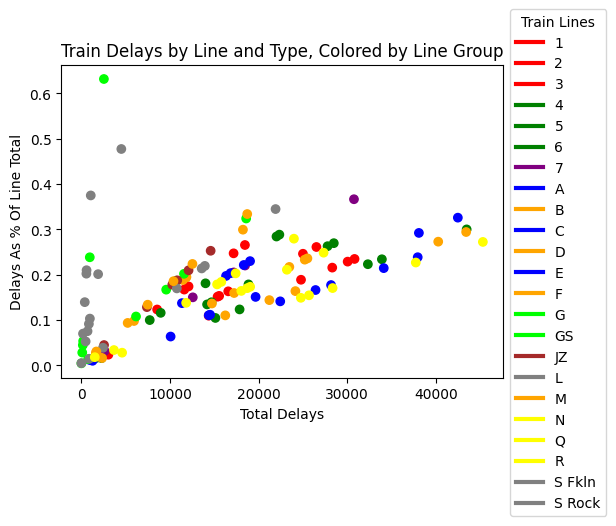

In [ ]:
#Make colors for the delay default category
train_colors = {'1':'red','2':'red','3':'red','4':'green','5':'green','6':'green','7':'purple','A':'blue','B':'orange','C':'blue','D':'orange',
'E':'blue','F':'orange','G':'lime','GS':'lime','JZ':'brown','L':'grey','M':'orange',
'N':'yellow','Q':'yellow','R':'yellow','S Fkln':'grey','S Rock':'grey'}

#And plot
plt.scatter(DelayGroup['delays'],DelayGroup['ratio'],c=DelayGroup['line'].map(train_colors))
plt.xlabel('Total Delays')
plt.ylabel('Delays As % Of Line Total')
plt.title('Train Delays by Line and Type, Colored by Line Group')
custom_legend = [plt.Line2D([0], [0], color=color,lw=1) for color in train_colors.values()]
leg = plt.legend(custom_legend, train_colors.keys(), title="Train Lines",bbox_to_anchor=(1.25, 1.2), loc = 'upper right')
lines = leg.get_lines()
for line in lines:
  line.set_linewidth(3)
plt.tight_layout()
plt.show()

To clean up the graph we will remove the G and S trains

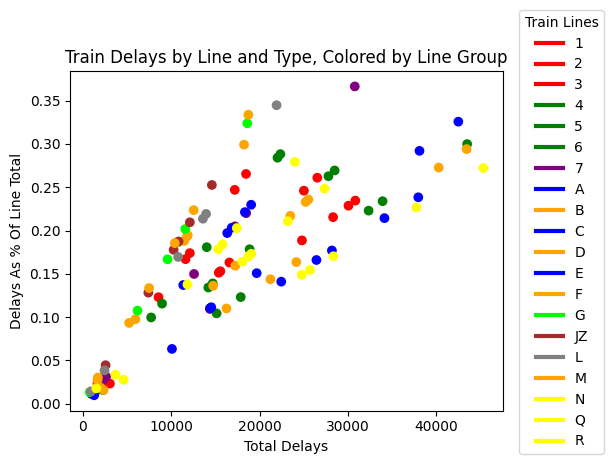

In [ ]:
#Look at dropping GS and S Fkln ands S Rock
TightDelayGroup = DelayGroup.drop(DelayGroup[DelayGroup['line'].isin(['GS','S Fkln','S Rock'])].index, axis = 0)

tight_train_colors = {'1':'red','2':'red','3':'red','4':'green','5':'green','6':'green','7':'purple','A':'blue','B':'orange','C':'blue','D':'orange',
'E':'blue','F':'orange','G':'lime','JZ':'brown','L':'grey','M':'orange',
'N':'yellow','Q':'yellow','R':'yellow'}

#And plot
plt.scatter(TightDelayGroup['delays'],TightDelayGroup['ratio'],c=TightDelayGroup['line'].map(tight_train_colors))
plt.xlabel('Total Delays')
plt.ylabel('Delays As % Of Line Total')
plt.title('Train Delays by Line and Type, Colored by Line Group')
custom_legend = [plt.Line2D([0], [0], color=color,lw=1) for color in tight_train_colors.values()]
leg = plt.legend(custom_legend, tight_train_colors.keys(), title="Train Lines",bbox_to_anchor=(1.25, 1.2), loc = 'upper right')
lines = leg.get_lines()
for line in lines:
  line.set_linewidth(3)
plt.tight_layout()
plt.show()

Lets look at this by colored by delay type and localness

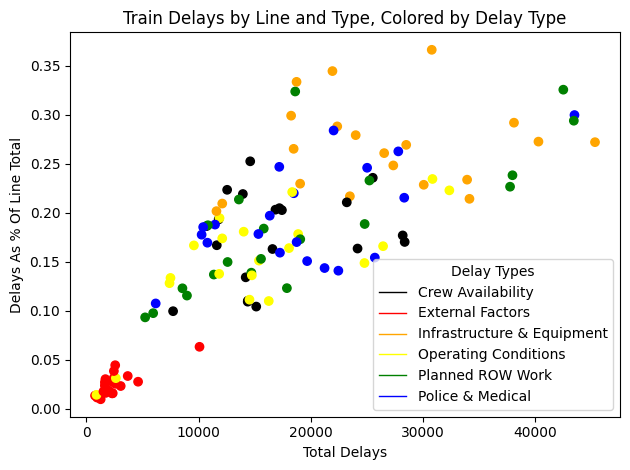

In [ ]:
#First by type of delay
report_colors = {'Crew Availability':'black', 'External Factors':'red',
       'Infrastructure & Equipment':'orange', 'Operating Conditions':'yellow',
       'Planned ROW Work':'green', 'Police & Medical':'blue'}

plt.scatter(TightDelayGroup['delays'],TightDelayGroup['ratio'],c=TightDelayGroup['reporting_category'].map(report_colors))
plt.xlabel('Total Delays')
plt.ylabel('Delays As % Of Line Total')
plt.title('Train Delays by Line and Type, Colored by Delay Type')
custom_legend = [plt.Line2D([0], [0], color=color,lw=1) for color in report_colors.values()]
plt.legend(custom_legend, report_colors.keys(), title="Delay Types",bbox_to_anchor=(1, 0), loc = 'lower right')
plt.tight_layout()
plt.show()

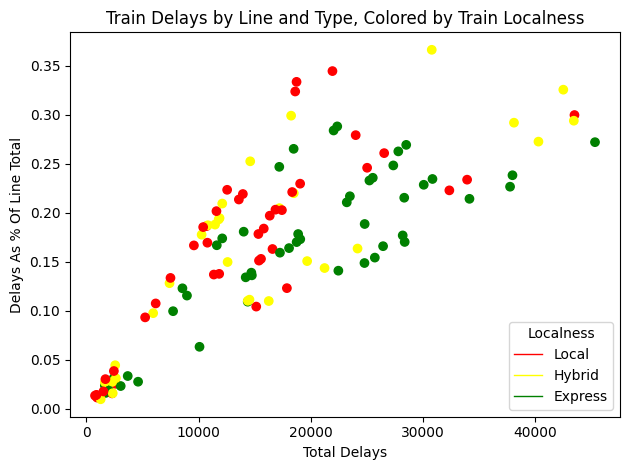

In [ ]:
#Lets look at 'local'ness

local_colors = {'1':'red','2':'green','3':'green','4':'green','5':'green','6':'red','7':'yellow','A':'green','B':'yellow','C':'red','D':'green',
'E':'yellow','F':'yellow','G':'red','GS':'red','JZ':'yellow','L':'red','M':'red',
'N':'green','Q':'green','R':'red','S Fkln':'red','S Rock':'red'}
#red - local, yellow - midway express, green - express

local_meaning = {'Local':'red','Hybrid':'yellow','Express':'green'}

plt.scatter(TightDelayGroup['delays'],TightDelayGroup['ratio'],c=TightDelayGroup['line'].map(local_colors))
plt.xlabel('Total Delays')
plt.ylabel('Delays As % Of Line Total')
plt.title('Train Delays by Line and Type, Colored by Train Localness')
custom_legend = [plt.Line2D([0], [0], color=color,lw=1) for color in local_meaning.values()]
plt.legend(custom_legend, local_meaning.keys(), title="Localness",bbox_to_anchor=(1, 0), loc = 'lower right')
plt.tight_layout()
plt.show()

### Now to create a reference of stops in each borough per line

In [ ]:
#We use station data to create a lookup
Stations = Stations.drop_duplicates(subset = 'Stop Name')
Stations.reset_index(drop=True, inplace = True)

#Lets use Delay Line Group
BCount = []
BxCount = []
MCount = []
QCount = []
TotalCount = []
for x in DelayLineGroup['line']:
    B = 0
    Bx = 0
    M = 0
    Q = 0
    T = 0
    for y in range(len(Stations['Daytime Routes'])):
        if x in Stations['Daytime Routes'][y]:
            T += 1
            if Stations['Borough'][y] == 'B':
                B += 1
            if Stations['Borough'][y] == 'Bx':
                Bx += 1
            if Stations['Borough'][y] == 'M':
                M += 1
            if Stations['Borough'][y] == 'Q':
                Q += 1
    TotalCount.append(T)
    BCount.append(B)
    BxCount.append(Bx)
    MCount.append(M)
    QCount.append(Q)

In [ ]:
#Append these columns to an existing table
DelayLineGroup['Total stops'] = TotalCount
DelayLineGroup['Manhattan stops'] = MCount
DelayLineGroup['Brooklyn stops'] = BCount
DelayLineGroup['Bronx stops'] = BxCount
DelayLineGroup['Queens stops'] = QCount
# print(DelayLineGroup.sort_values(by = 'delays', ascending = False))
display(DelayLineGroup.sort_values(by = 'delays', ascending = False))

,line,delays,Total stops,Manhattan stops,Brooklyn stops,Bronx stops,Queens stops
18,N,166457,23,9,7,0,7
7,A,159198,43,17,8,0,18
12,F,147647,46,14,22,0,10
5,6,144997,29,11,0,18,0
1,2,131408,39,8,14,17,0
11,E,130419,21,11,0,0,10
19,Q,110054,24,7,17,0,0
10,D,108186,29,10,9,10,0
3,4,105746,22,7,5,10,0
0,1,101645,25,22,0,3,0


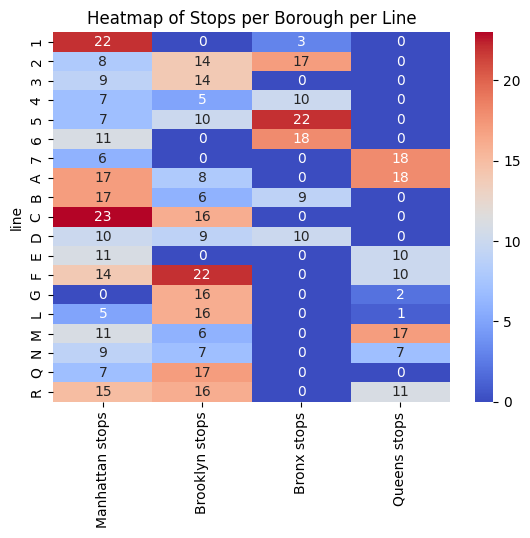

In [ ]:
#Lets make a heatmap
HeatMapBorough = DelayLineGroup.drop(['delays','Total stops'], axis = 1)
HeatMapBorough = HeatMapBorough.set_index('line')
HeatMapBorough = HeatMapBorough.drop(['GS','JZ','S Fkln','S Rock'], axis = 0)
sns.heatmap(HeatMapBorough, annot=True, cmap = 'coolwarm')
plt.title('Heatmap of Stops per Borough per Line')
plt.show()

We have this heatmap for further investigations and to pass to the accessibility team

We see that trains have different distribution among stops across boroughs

### Now to produce an overall look at 'major delays' and 'delays'

Frequency of Simple Delays Per Reporting Category

In [ ]:
#extracting the reporting category and corresponding summed column values
SimpDelays = Delays.groupby(['reporting_category']).sum()
#extracting just the 'delays' column which has been summed by reporting category
SimpDelays = SimpDelays['delays']

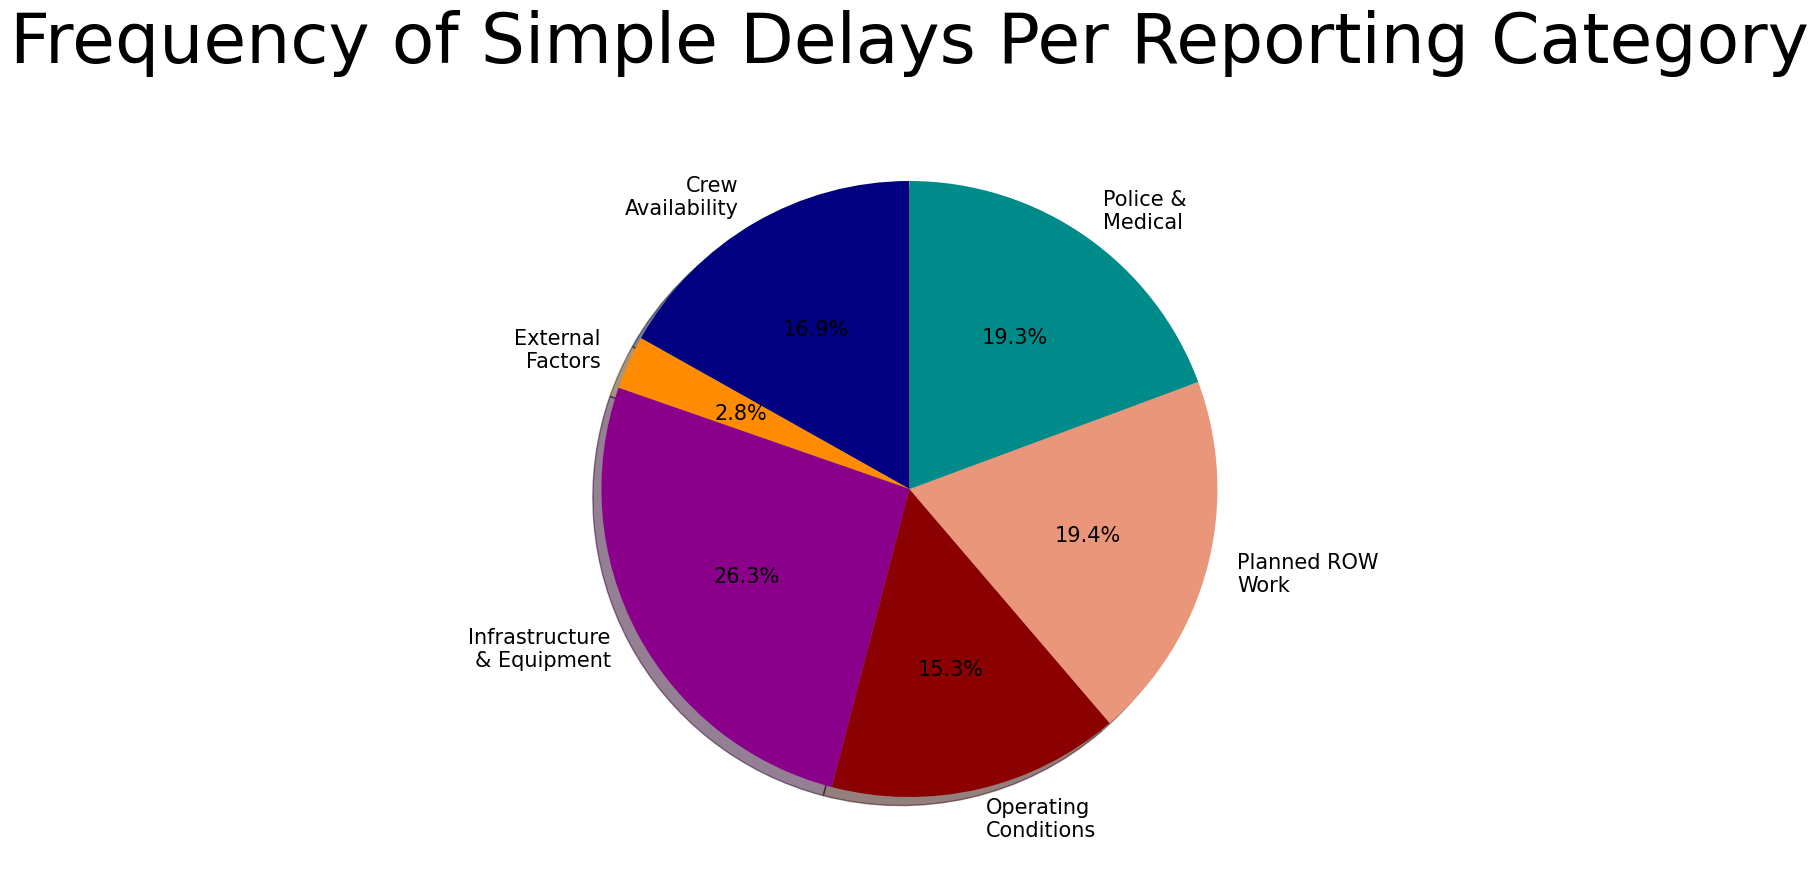

In [ ]:
#assigning colors to the unique values in the 'reporting category' column
reporting_category_colors = {
    'Crew Availability': 'navy',
    'Police & Medical': 'darkcyan',
    'External Factors': 'darkorange',
    'Infrastructure & Equipment': 'darkmagenta',
    'Operating Conditions': 'darkred',
    'Planned ROW Work': 'darksalmon'
}

#asigning colors to the values in simple delays
colors = [reporting_category_colors.get(cat, "gray") for cat in SimpDelays.index]

#wrapping labels with a length of 15 for easier readability
def wrap_labels(x, width=10):
    return '\n'.join(textwrap.wrap(x, width=width))

wrapped_labels = [wrap_labels(label, width=15,) for label in SimpDelays.index]

#assinging plot details
fig, ax = plt.subplots(figsize=(20,10))
SimpDelays.plot(
    kind='pie',
    labels=wrapped_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    shadow=True,
    textprops={'fontsize': 15,},
    legend=False,
    ax=ax)

#removing any axis labels
ax.axis('off')

#assiging plot title
plt.title('Frequency of Simple Delays Per Reporting Category',
          fontsize=50,
          pad=30)

plt.show()

Infrastructure and Equipment have the most number of delays

### Deep dive on the frequency of Simple Delays Per SubCategory

In [ ]:
#pulling the grouped subcategories and their correspondings summed columns
SimpDelays2 = Delays.groupby(['subcategory']).sum()

In [ ]:
#defining a dictionary with color designations
simple_delay_colors = {
    'Crew Availability': 'navy',
    'Other Operating Environment': 'darkred',
    'Service Management': 'darkcyan',
    'Persons on Roadbed': 'darkcyan',
    'Public Conduct, Crime, Police Response': 'darkcyan',
    'Sick/Injured Customer': 'darkcyan',
    'Capital Work - Other Planned ROW': 'darksalmon',
    'Subways Maintenance': 'darksalmon',
    'Work Equipment': 'darksalmon',
    'Other Planned ROW Work': 'darksalmon',
    'Insufficient Supplement Schedule': 'darksalmon',
    'External Debris on Roadbed': 'darkorange',
    'External Agency or Utility': 'darkorange',
    'Inclement Weather': 'darkorange',
    'Braking': 'darkmagenta',
    'Door-Related': 'darkmagenta',
    'Fire, Smoke, Debris': 'darkmagenta',
    'Other - CE': 'darkmagenta',
    'Other Infrastructure': 'darkmagenta',
    'Other - Sig': 'darkmagenta',
    'Propulsion': 'darkmagenta',
    'Rail and Roadbed': 'darkmagenta',
    'Service Delivery': 'darkmagenta',
    'Train Brake Activation - Cause Unknown': 'darkmagenta',
    'Other Internal Disruptions': 'darkmagenta',
    'Signal Modernization Capital Project': 'darkmagenta'
}

#pulling the delayed summed values and listing in asceninding order
SimpDelays2 = SimpDelays2['delays']
SimpDelays2 = SimpDelays2.sort_values(ascending=True)

colors = [simple_delay_colors[subcategory] for subcategory in SimpDelays2.index]


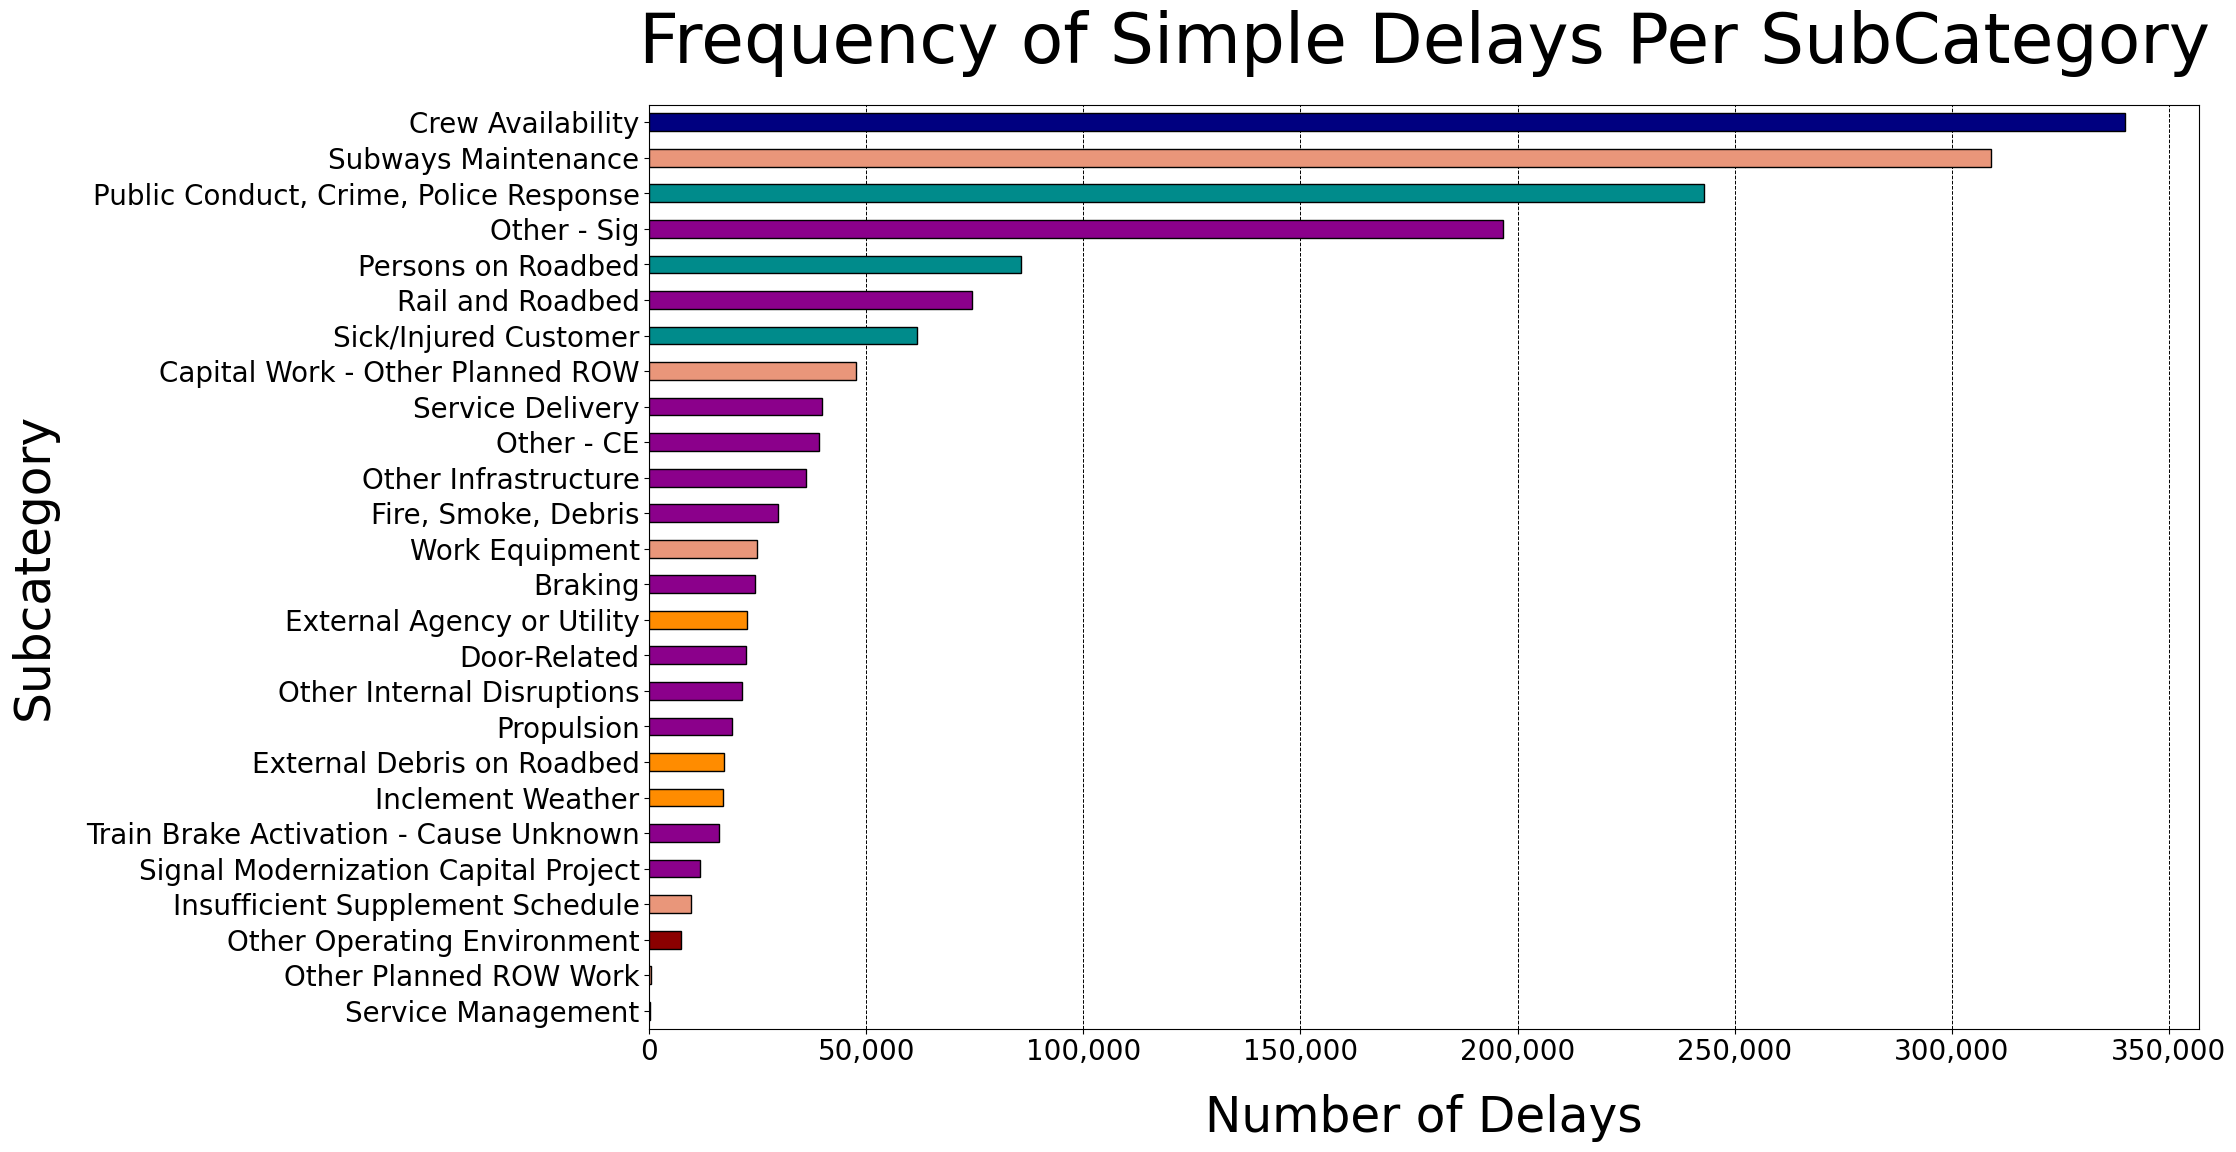

In [ ]:
#defining plot details
fig, ax=plt.subplots(figsize=(20,12))
SimpDelays2.plot(
    kind='barh',
    color=colors,
    edgecolor='black',
    legend=False,
    zorder=3,
    ax=ax)
#defining details of the plot
plt.title('Frequency of Simple Delays Per SubCategory',
          fontsize=50,
          pad=30)
#x axis details
plt.xlabel('Number of Delays',
          fontsize = 35,
          labelpad=20)

#y axis details
plt.ylabel('Subcategory',
          fontsize=35,
          labelpad=20)

#including commas for x axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

#tick size for each axis
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#defing the grid and details
plt.grid(axis='x',
         linestyle='--',
         linewidth=0.7,
         alpha=1.0,
         color='black')

plt.show()

Surprisingly 'Crew Availability' is a major cause for delays.

### Frequency of Major Delays Per Reporting Category

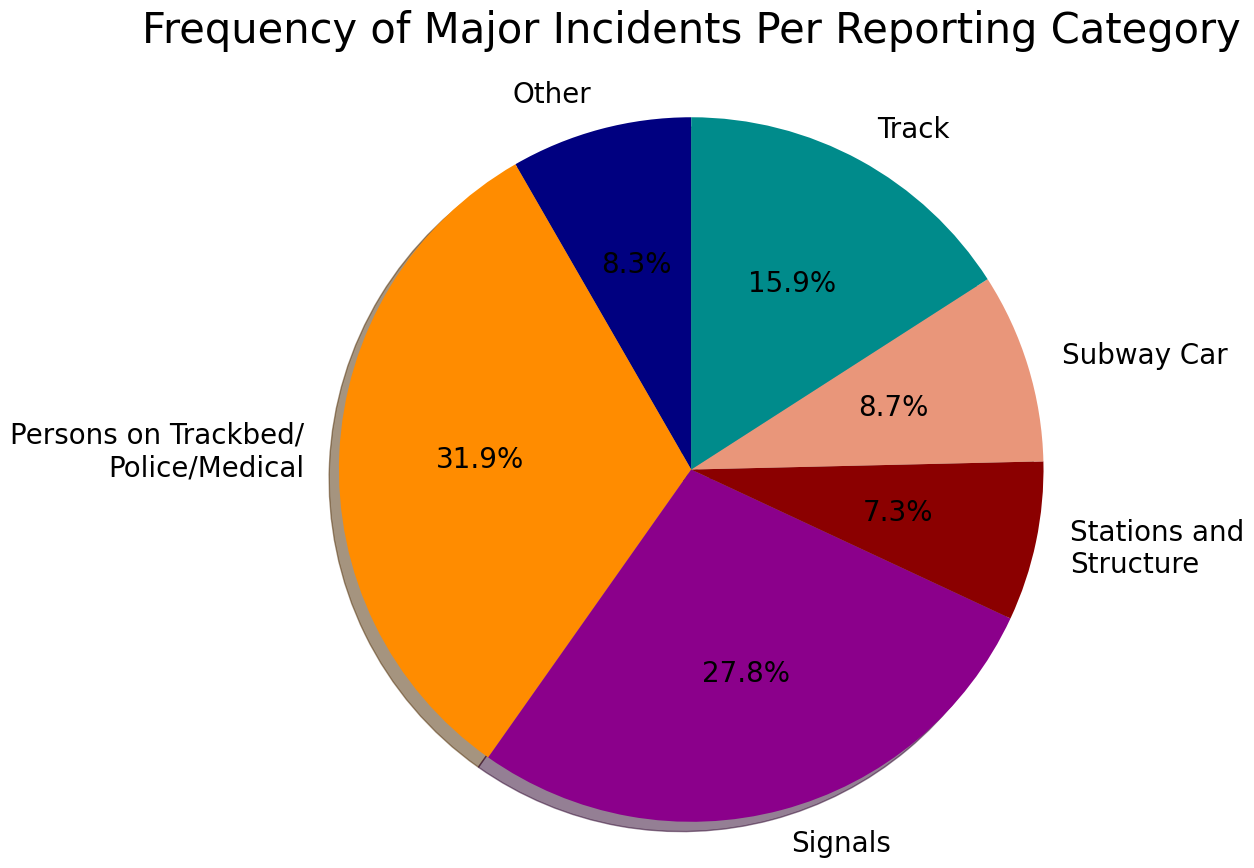

In [ ]:
#grouping by category and counting the sum over the 'count' column.
MajorDelays = MajorIncidents.groupby(['category']).sum()['count']

#calling the wrapped labels function
wrapped_labels = [wrap_labels(label, width=20) for label in MajorDelays.index]

#defining colors
MajorDelays_reporting_category_colors = {
    'Other': 'navy',
    'Track': 'darkcyan',
    'Persons on Trackbed/Police/Medical': 'darkorange',
    'Signals': 'darkmagenta',
    'Stations and Structure': 'darkred',
    'Subway Car': 'darksalmon'
}

#assinging colors
colors = [MajorDelays_reporting_category_colors[subcat] for subcat in MajorDelays.index]

#defining details of the plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figsize for better visualization
MajorDelays.plot.pie(
    labels=wrapped_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    shadow=True,
    textprops={'fontsize': 20,}
)

plt.title('Frequency of Major Incidents Per Reporting Category',
          fontsize=30,
          pad=30)

#turning off unneccessary axis labels
ax.axis('off')

#equaling scaling
plt.axis('equal')

plt.show()


Persons on Tackbed/Police/Medical have the most major incidents.

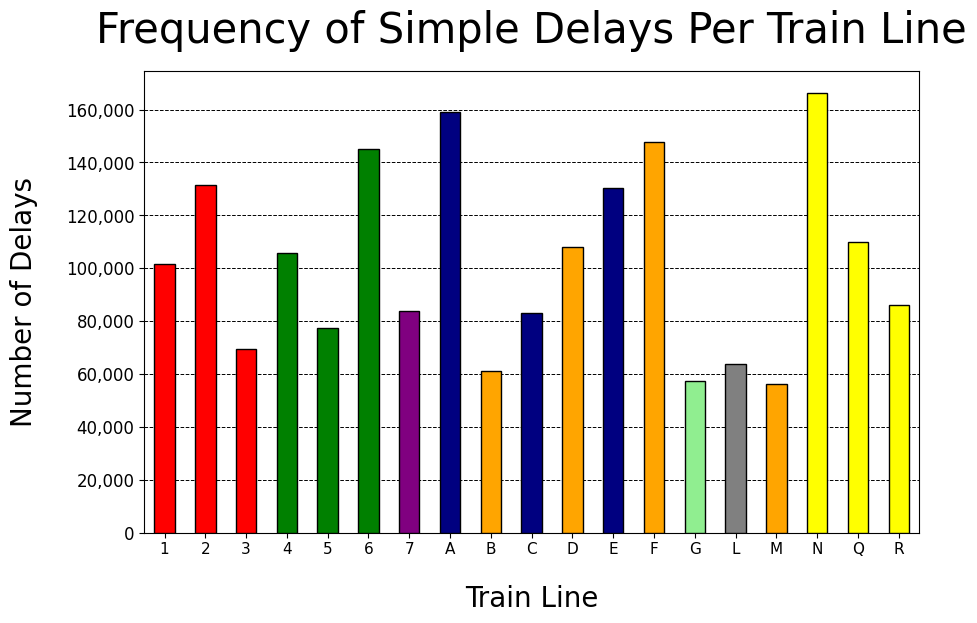

In [ ]:
#defining train lines to be used in the graph
TrainLines = ['1', '2', '3', '4', '5', '6', '7',
              'A', 'B', 'C', 'D', 'E', 'F', 'G',
              'L', 'M', 'N', 'Q', 'R']

#extracting the unique 'line' categories and summing the remaining categories from the original data set.
SimpLineDelays = Delays.groupby(['line']).sum()
#filtering the dataframe to extract only the values in the train lines list.
filtered_SimpLineDelays = SimpLineDelays[SimpLineDelays.index.isin(TrainLines)]
#defining train line colors
train_line_colors= {
        '1':'Red',
        '2':'Red',
        '3':'Red',
        '4':'Green',
        '5':'Green',
        '6':'Green',
        '7':'Purple',
        'A':'Navy',
        'B':'Orange',
        'C':'Navy',
        'D':'Orange',
        'E':'Navy',
        'F':'Orange',
        'G':'Lightgreen',
        'L':'Grey',
        'M':'Orange',
        'N':'Yellow',
        'Q':'Yellow',
        'R':'Yellow',
        'W':'Yellow'
}

#assigning defined colors to the values in filtered
colors = [train_line_colors.get(line, "black") for line in filtered_SimpLineDelays.index]

#defining plot details
fig, ax=plt.subplots(figsize=(10,6))
filtered_SimpLineDelays['delays'].plot(
    kind='bar',
    color=colors,
    edgecolor='black',
    legend=False,
    zorder=3,
    ax=ax)

#defining plot title
plt.title('Frequency of Simple Delays Per Train Line',
          fontsize=30,
          pad=20)

#defining x label
plt.xlabel('Train Line',
           fontsize= 20,
           labelpad=20)

#defining y label
plt.ylabel('Number of Delays',
           fontsize=20,
           labelpad=20)

#detailing x axis labels
plt.xticks(fontsize=11,
           rotation=0)

#adding commas for the numbers on the y axis for easier readability
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.yticks(fontsize=12)

#adding grid on y axis for easier readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=1.0, color='black')

plt.show()

Red, Orange, Blue, Yellow and Green lines have the most amount of simple delays

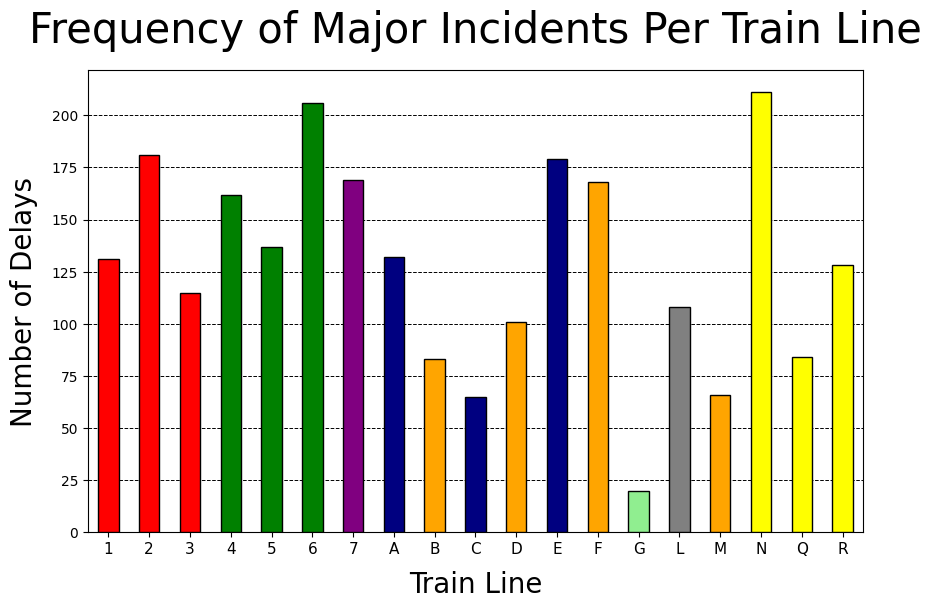

In [ ]:
#filtering out major incidents data frame by grouping by 'line' and summing over corresponding columns
MajorLineDelays = MajorIncidents.groupby(['line']).sum()
filtered_MajorLineDelays = MajorLineDelays[MajorLineDelays.index.isin(TrainLines)]

#defining colors of the train lines for the bar chart
colors = [train_line_colors.get(line, "black") for line in filtered_MajorLineDelays.index]

#defining details of the plot
fig, ax=plt.subplots(figsize=(10,6))
filtered_MajorLineDelays['count'].plot(
    kind='bar',
    color=colors,
    edgecolor='black',
    legend=False,
    zorder=3,
    ax=ax)

#defining plot title
plt.title('Frequency of Major Incidents Per Train Line',
          fontsize=30,
          pad=20)

#defining x label
plt.xlabel('Train Line',
           fontsize=20,
           labelpad=10)

#definig y label
plt.ylabel('Number of Delays',
           fontsize=20,
           labelpad=10)

#detailing x axis labels
plt.xticks(fontsize=11,
           rotation=0)

#defining grid on y asix for easier readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=1.0, color='black')


plt.show()

Red, Orange, Green, Yellow and Blue lines have the highest amount of major incidents.

In [ ]:
filtered_MajorLineDelays['color'] = colors
filtered_SimpLineDelays['color'] = colors

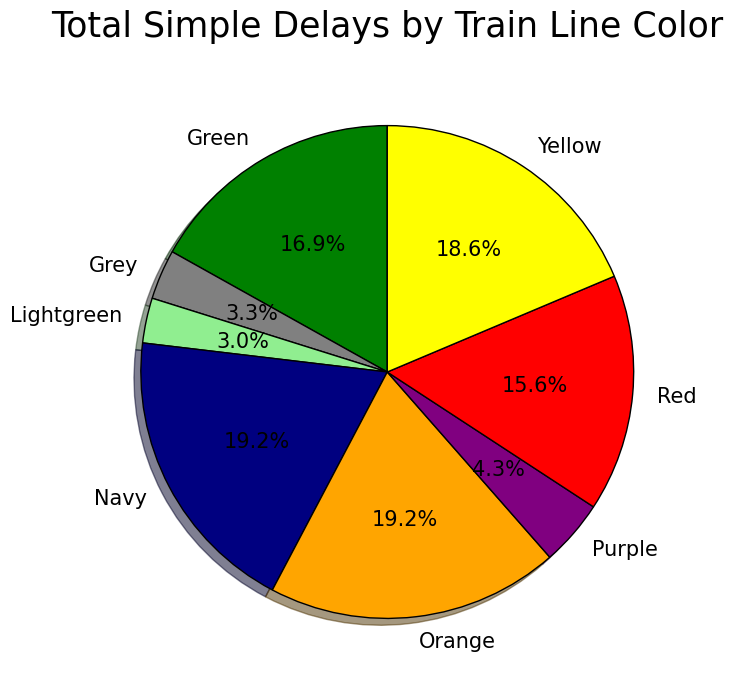

In [ ]:
color_grouped_delays = filtered_SimpLineDelays.groupby('color')['delays'].sum()


fig, ax = plt.subplots(figsize=(8,8))
color_grouped_delays.plot.pie(
    labels=color_grouped_delays.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=color_grouped_delays.index,
    shadow=True,
    textprops={'fontsize': 15, 'color': 'black'},
    wedgeprops={'edgecolor': 'black'},
    ax=ax
)
ax.axis('off')

plt.title('Total Simple Delays by Train Line Color', fontsize=25, pad=20)


plt.show()

The yellow, red, orange, green and blue  line groups experience  the most delays.

Alternate Plot for Total Simple Delays by Train Line Color using plotly

In [ ]:
# Summing the number of delays based on color
color_grouped_delays = filtered_SimpLineDelays.groupby('color')['delays'].sum()

# Create a Pie chart using Plotly
fig = px.pie(
    names=color_grouped_delays.index,  # Labels for the pie chart (train line colors)
    values=color_grouped_delays.values,  # Values (sum of delays)
    title='Total Simple Delays by Train Line Color',  # Title for the chart
    labels={'names': 'Train Line Color', 'values': 'Total Delays'},  # Custom labels
    color=color_grouped_delays.index,  # Color by the 'color' column
    color_discrete_map={key: value for key, value in zip(color_grouped_delays.index, color_grouped_delays.index)}  # Custom color mapping
)

# Update layout for font size and other plot customization
fig.update_layout(
    title_font_size=25,  # Title font size
    title_x=0.5,  # Center the title
    font=dict(size=15),  # Font size for labels
    showlegend=True  # Show legend
)

# Show the plot
fig.show()

![](https://drive.google.com/uc?export=view&id=1O4un5l2rSMzAEhDnti1K0Q5OwOYZ3Tog)


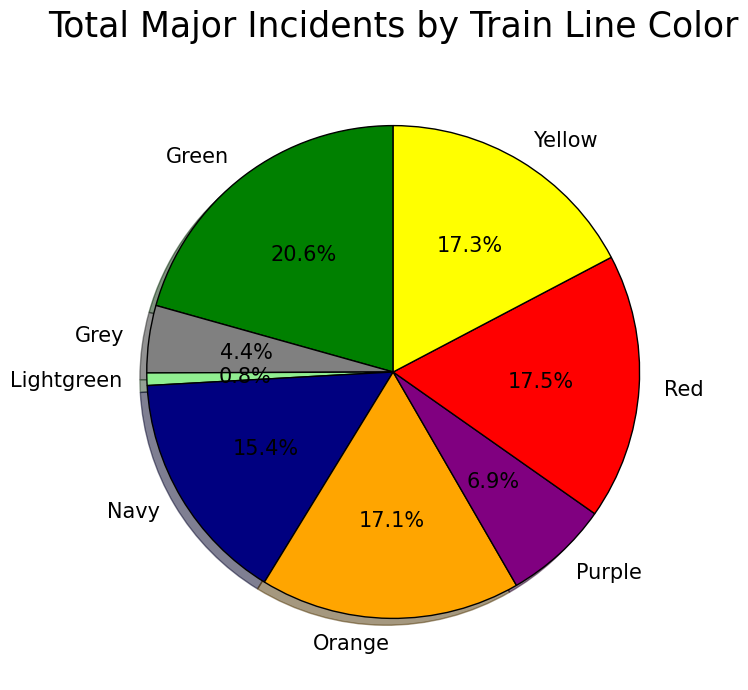

In [ ]:
#summing number of delays based on color.
color_grouped_delays = filtered_MajorLineDelays.groupby('color')['count'].sum()

#defining plot details
fig, ax = plt.subplots(figsize=(8, 8))
color_grouped_delays.plot.pie(
    labels=color_grouped_delays.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=color_grouped_delays.index,
    shadow=True,
    textprops={'fontsize': 15, 'color': 'Black'},
    wedgeprops={'edgecolor': 'black'},
    ax=ax
)

#turning off axis labels
ax.axis('off')

#defining plot title
plt.title('Total Major Incidents by Train Line Color', fontsize=25, pad=20)

plt.show()

The green line group had the most significant increase in percent of total (4%) from normal delays

Alternate Plot for Total Major Incidents by Train Line Color using plotly

In [ ]:
# Summing the number of delays based on color
color_grouped_delays = filtered_MajorLineDelays.groupby('color')['count'].sum()

# Create a Pie chart using Plotly
fig = px.pie(
    names=color_grouped_delays.index,  # Labels for the pie chart
    values=color_grouped_delays.values,  # Values (sum of delays)
    title='Total Major Incidents by Train Line Color',  # Title for the chart
    labels={'names': 'Train Line Color', 'values': 'Total Delays'},
    color=color_grouped_delays.index,  # Color by the 'color' column
    color_discrete_map={key: value for key, value in zip(color_grouped_delays.index, color_grouped_delays.index)}  # Use color groups
)

# Update layout for font size and other plot customization
fig.update_layout(
    title_font_size=25,
    title_x=0.5,  # Center the title
    font=dict(size=15),  # Font size for labels
    showlegend=True  # Show legend
)

# Show the plot
fig.show()

![](https://drive.google.com/uc?export=view&id=1onM4j-A6try6V2kIrRrHZu9WEijWn_o-)
